# Multi-class classification

In [1]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from torch import nn
from torchmetrics import Accuracy, Precision, Recall, ConfusionMatrix

## Generate a dataset

In [2]:
num_classes = 4
num_features = 2
random_seed = 42

In [3]:
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=num_features,
                            centers=num_classes,
                            cluster_std=1.5,
                            random_state=random_seed)

In [4]:
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


In [5]:
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(
    X_blob,
    y_blob,
    test_size=0.2,
    random_state=random_seed
)

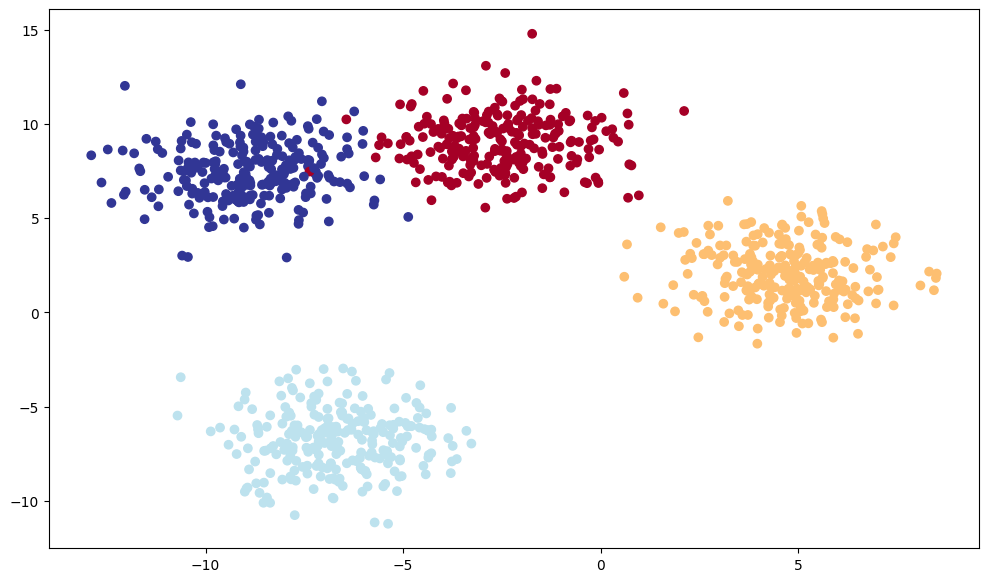

In [6]:
plt.figure(figsize=(12, 7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.show()

## Train a model

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [8]:
class BlobModel(nn.Module):
    def __init__(self, input_features: int, output_features: int, hidden_units: int = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer_stack(x)


In [9]:
model = BlobModel(input_features=num_features, 
                  output_features=num_classes,
                  hidden_units=8).to(device)
model

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr=0.1)

In [11]:
def accuracy(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    return 100 * correct / len(y_pred)

In [12]:
torch.manual_seed(42)
epochs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

epoch_values = []
training_loss_values = []
training_accuracy_values = []
testing_loss_values = []
testing_accuracy_values = []

for epoch in range(epochs):
    # TRAINING
    model.train()

    # Forward pass
    y_logits = model(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

    # Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy(y_true=y_blob_train, y_pred=y_pred)

    # Zero grad
    optimiser.zero_grad()

    # Loss backwards
    loss.backward()

    # Optimiser step
    optimiser.step()

    # TESTING
    model.eval()
    with torch.inference_mode():
        test_logits = model(X_blob_test)
        test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy(y_true=y_blob_test, y_pred=test_pred)

    if epoch % 10 == 0:
        epoch_values.append(epoch)
        training_loss_values.append(loss.detach().numpy())
        training_accuracy_values.append(acc)
        testing_loss_values.append(test_loss.detach().numpy())
        testing_accuracy_values.append(test_acc)

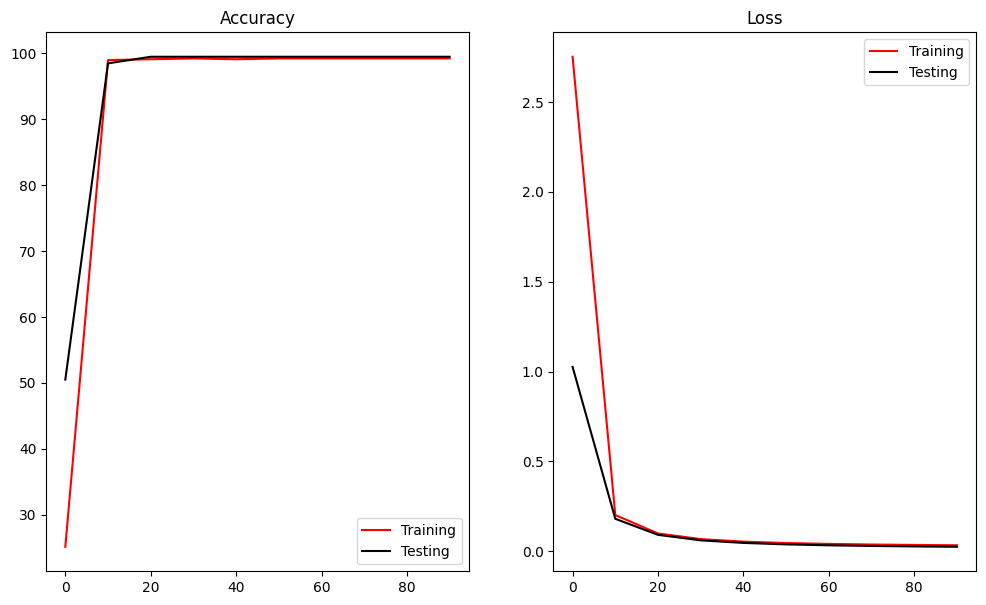

In [13]:
plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.plot(epoch_values, training_accuracy_values, 'r', label='Training')
plt.plot(epoch_values, testing_accuracy_values, 'k', label='Testing')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epoch_values, training_loss_values, 'r', label='Training')
plt.plot(epoch_values, testing_loss_values, 'k', label='Testing')
plt.title('Loss')
plt.legend()

plt.show()

## Evaluate the model

In [14]:
from helper_functions import plot_decision_boundary

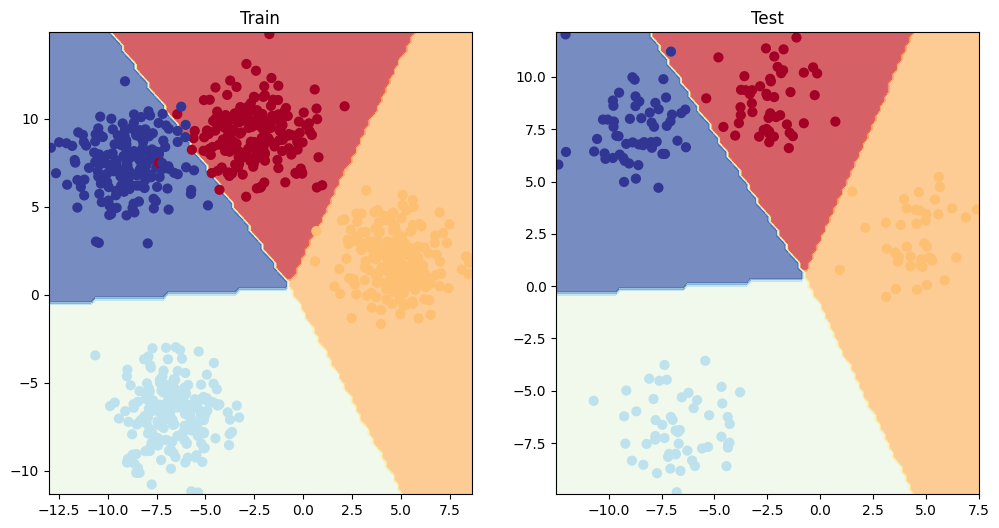

In [15]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

In [16]:
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

In [17]:
# Accuracy = proportion of predictions the classifier gets right
accuracy = Accuracy(task='multiclass', num_classes=num_classes).to(device)
accuracy(y_preds, y_blob_test)

tensor(0.9950)

In [18]:
# Precision = TP / (TP + FP)
precision = Precision(task='multiclass', num_classes=num_classes).to(device)
precision(y_preds, y_blob_test)

tensor(0.9950)

In [19]:
# Recall = TP / (TP + FN)
recall = Recall(task='multiclass', num_classes=num_classes).to(device)
recall(y_preds, y_blob_test)

tensor(0.9950)

In [20]:
conf_matrix = ConfusionMatrix(task='multiclass', num_classes=num_classes).to(device)
conf_matrix(y_preds, y_blob_test)

tensor([[49,  0,  0,  0],
        [ 0, 41,  0,  0],
        [ 0,  0, 53,  0],
        [ 1,  0,  0, 56]])